# NLP. Task №3. Movie Review Sentiment Analysis

**by Maria Ismailova**

The task: Classify the sentiment of sentences from the Rotten Tomatoes dataset

1. Choose and argue your measure of a test's accuracy
2. Build data processing and classification pipeline (compare word-embeddings vs classical methods)
3. Tune  your model

While completing this task I used:
- NLP lectures
- several Internet-based articles (given in lectures)
- some examples of coding

Since we are exploring sentiments in this task, they are to be labeled: 

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive
 
4 - positive

# Data inspection

In [112]:
# loading the libraries

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from gensim.models import word2vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [49]:
# loading the dataset

df_train = pd.read_csv("train.tsv", sep = "\t")
df_test = pd.read_csv("test.tsv", sep = "\t")
df_sub = pd.read_csv("sampleSubmission.csv")

**Inspecting train dataset**

In [50]:
df_train.head(5)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [51]:
df_train.tail(5)

,PhraseId,SentenceId,Phrase,Sentiment
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2
156059,156060,8544,chortles,2


In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [53]:
df_train.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [54]:
df_train.shape[0]

156060

In [55]:
df_train.shape[1]

4

**Inspecting test dataset**

In [56]:
df_test.head(5)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [57]:
df_test.tail(5)

,PhraseId,SentenceId,Phrase
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded
66291,222352,11855,predictable scenario


In [58]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
PhraseId      66292 non-null int64
SentenceId    66292 non-null int64
Phrase        66292 non-null object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [59]:
df_test.describe()

,PhraseId,SentenceId
count,66292.00000,66292.000000
mean,189206.50000,10114.909144
std,19136.99636,966.787807
min,156061.00000,8545.000000
25%,172633.75000,9266.000000
50%,189206.50000,10086.000000
75%,205779.25000,10941.000000
max,222352.00000,11855.000000


In [60]:
df_test.shape[0]

66292

In [61]:
df_test.shape[1]

3

**Inspecting sub dataset**

In [62]:
df_sub.head(5)

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [63]:
df_sub.tail(5)

,PhraseId,Sentiment
66287,222348,2
66288,222349,2
66289,222350,2
66290,222351,2
66291,222352,2


In [64]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 2 columns):
PhraseId     66292 non-null int64
Sentiment    66292 non-null int64
dtypes: int64(2)
memory usage: 1.0 MB


In [65]:
df_sub.describe()

,PhraseId,Sentiment
count,66292.00000,66292.0
mean,189206.50000,2.0
std,19136.99636,0.0
min,156061.00000,2.0
25%,172633.75000,2.0
50%,189206.50000,2.0
75%,205779.25000,2.0
max,222352.00000,2.0


In [66]:
df_sub.shape[0]

66292

In [67]:
df_sub.shape[1]

2

## Checking the sample imbalance problem

In [68]:
# checking the imbalance problem

df_train['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [69]:
# relative frequency

df_train['Sentiment'].value_counts(normalize = True)

2    0.509945
3    0.210989
1    0.174760
4    0.058990
0    0.045316
Name: Sentiment, dtype: float64

'Distribution of Sentiment in reviews'

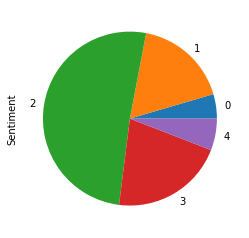

In [70]:
# graph of distribution of categories

df_train.groupby('Sentiment').Sentiment.count().plot.pie()
('Distribution of Sentiment in reviews')

## Trying to deal with sample imbalance problem

In [71]:
# naming the classes

sent_2 = df_train[df_train['Sentiment'] == 2]
sent_3 = df_train[df_train['Sentiment'] == 3]
sent_1 = df_train[df_train['Sentiment'] == 1]
sent_4 = df_train[df_train['Sentiment'] == 4]
sent_0 = df_train[df_train['Sentiment'] == 0]

In [72]:
# oversampling the classes

df_train = df_train.append([sent_3])
df_train = df_train.append([sent_1,sent_1])
df_train = df_train.append([sent_4,sent_4,sent_4,sent_4,sent_4,sent_4,sent_4])
df_train = df_train.append([sent_0,sent_0,sent_0,sent_0,sent_0,sent_0,sent_0,sent_0,sent_0])

In [73]:
# checking the imbalance problem

df_train['Sentiment'].value_counts()

1    81819
2    79582
4    73648
0    70720
3    65854
Name: Sentiment, dtype: int64

In [74]:
# relative frequency

df_train['Sentiment'].value_counts(normalize = True)

1    0.220167
2    0.214147
4    0.198179
0    0.190300
3    0.177206
Name: Sentiment, dtype: float64

'Distribution of Sentiment in reviews'

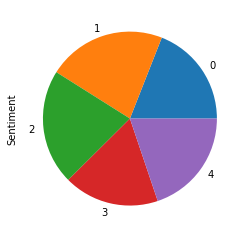

In [75]:
# checking the resuts of dealing with imbalance problem

df_train.groupby('Sentiment').Sentiment.count().plot.pie()
('Distribution of Sentiment in reviews')

# Building classical model

## Preparing data with TfidVectorizer

In [76]:
# vectorizing text

tfidf = TfidfVectorizer(sublinear_tf = True, min_df = 30, norm = 'l2', ngram_range = (1, 2), stop_words = 'english')
df_train2 = tfidf.fit_transform(df_train.Phrase)
df_train2.shape

(371623, 22844)

In [77]:
# splitting the data on train and test samples

X_train, x_test, Y_train, y_test = train_test_split(df_train2, df_train['Sentiment'], test_size = 0.2, random_state = 20)

In [101]:
# checking samples' shape

print(X_train.shape[0], X_train.shape[1], x_test.shape[0], x_test.shape[1])

297298 22844 74325 22844


## Logistic Regression

In [83]:
# building logistic regression classifier

LR_clf = LogisticRegression()
LR_clf.fit(X_train, Y_train)
LR_clf_pred = LR_clf.predict(x_test)

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [84]:
# confusion matrix for logistic regression

print(confusion_matrix(y_test, LR_clf_pred))

[[11590  2057   249    80    81]
 [ 2925  9562  3061   649   262]
 [  496  2610 10574  1683   531]
 [  220   872  3027  5737  3377]
 [   42   159   359  1643 12479]]


In [85]:
# accuracy score for logistic regression

print(accuracy_score(y_test, LR_clf_pred))

0.671940800538177


In [88]:
# classification report for logistic regression

print(classification_report(y_test, LR_clf_pred))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79     14057
           1       0.63      0.58      0.60     16459
           2       0.61      0.67      0.64     15894
           3       0.59      0.43      0.50     13233
           4       0.75      0.85      0.79     14682

   micro avg       0.67      0.67      0.67     74325
   macro avg       0.67      0.67      0.66     74325
weighted avg       0.66      0.67      0.67     74325



## Tuning Logistic Regression

In [186]:
tuned_parameters = {'C': [0.5, 1, 5, 10, 50]}
LR_clf_tuned = GridSearchCV(LogisticRegression(solver = 'liblinear'), tuned_parameters, cv = 10, scoring = "f1_weighted")
LR_clf_tuned.fit(X_train, Y_train)

print("Best parameters:", LR_clf_tuned.best_params_)
print("Best score:", LR_clf_tuned.best_score_)

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best parameters: {'C': 50}
Best score: 0.7025726184998902


# Building word embeddings

## Preparing data with Word2Vec

Before starting to work with word2vec we should clean our data: remove punctuation marks, capital letters, numbers, stopwords and empty phrases.

In [98]:
# removing punctuation
df_train ['Phrase'] = df_train['Phrase'].str.replace('[^\w\s]', '')

# converting to the lower case
df_train ['Phrase'] = df_train['Phrase'].map(lambda x: x.lower())

# removing digits
df_train ['Phrase'] = df_train['Phrase'].str.replace('[0-9]', '')

# removing stopwords
stop = stopwords.words('english')
df_train['Phrase'] = df_train['Phrase'].replace(stop, '')

# removing empty Phrases
df_train [df_train['Phrase'].str.len() == 0].head()

,PhraseId,SentenceId,Phrase,Sentiment
3,4,1,,2
6,7,1,,2
13,14,1,,2
16,17,1,,2
18,19,1,,2


In [102]:
# checking samples' shape

df_train.shape[0], df_train.shape[1]

(371623, 4)

In [103]:
# creating vocabulary function (tokenizing, lemmatizing)

def voc(train):
    phrases = []
    for phrase in tqdm(df_train['Phrase']):
        tokens = word_tokenize(phrase)
        lemmas = [WordNetLemmatizer().lemmatize(i) for i in tokens]
        phrases.append(lemmas)
    return(phrases)

In [104]:
# applying created vocabulary function for our train dataset

voc_train = voc(df_train)

100%|██████████| 371623/371623 [00:54<00:00, 6800.41it/s]


In [110]:
# checking samples' length

len(voc_train)

371623

Now we will apply Word2Vec embeddings to our newly created sample with following parameters:

- min_count = 30: ignores all words with total frequency lower than this
- sample = 1e-2: the threshold for configuring which higher-frequency words are randomly downsampled
- size = 100: size of the NN layers
- window = 30: maximum distance between the current and predicted word within a sentence
- workers = 10: for training parallelization, to speed up training

In [173]:
# applying Word2Vec to created sample

model_word2vec = word2vec.Word2Vec(voc_train, min_count = 30, sample = 1e-2, size = 100, window = 30, workers = 10)

After applying Word2Vec model for created sample we should create vectors from our new model for futher application of classifiers

In [174]:
# defining functions for creation of average word vectots

def FeatureVec(words, model, num_features):
    
    # pre-initializing an enpty numpy array
    featureVec = np.zeros((num_features), dtype = "float32")
    nwords = 0
    
    # converting Index2word to a set
    index2word_set = set(model.wv.index2word)
    
    # adding words' feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            
    # dividing the result by the number of words to get the average
    if(nwords != 0):
        featureVec = np.divide(featureVec, nwords)
    
    return featureVec

In [176]:
# defining functions for creation of average word vectots

def AvgFeatureVec(sentences, model, num_features):
    OverallFeatureVectors = []
    for sentence in tqdm(sentences):
        OverallFeatureVectors.append(FeatureVec(sentence, model, num_features)) 
    return OverallFeatureVectors

In [179]:
# applying created functions

word2vec_train = AvgFeatureVec(voc_train, model_word2vec, num_features)

  0%|          | 0/371623 [00:00<?, ?it/s]/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
100%|██████████| 371623/371623 [04:50<00:00, 1279.21it/s]


In [180]:
# splitting the data on train and test samples

X_train_2, x_test_2, Y_train_2, y_test_2 = train_test_split(word2vec_train, df_train.Sentiment.values, test_size = 0.2)

## Logistic Regression

In [185]:
# building logistic regression classifier

LR_clf_word2vec = LogisticRegression()
LR_clf_word2vec.fit(X_train_2, Y_train_2)
LR_clf_word2vec_pred = LR_clf_word2vec.predict(x_test_2)

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [182]:
# confusion matrix for logistic regression

print(confusion_matrix(y_test, LR_clf_word2vec_pred))

[[11590  2057   249    80    81]
 [ 2925  9562  3061   649   262]
 [  496  2610 10574  1683   531]
 [  220   872  3027  5737  3377]
 [   42   159   359  1643 12479]]


In [183]:
# accuracy score for logistic regression

print(accuracy_score(y_test, LR_clf_word2vec_pred))

0.671940800538177


In [184]:
# classification report for logistic regression

print(classification_report(y_test, LR_clf_word2vec_pred))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79     14057
           1       0.63      0.58      0.60     16459
           2       0.61      0.67      0.64     15894
           3       0.59      0.43      0.50     13233
           4       0.75      0.85      0.79     14682

   micro avg       0.67      0.67      0.67     74325
   macro avg       0.67      0.67      0.66     74325
weighted avg       0.66      0.67      0.67     74325



In [188]:
tuned_parameters = {'C': [0.5, 1, 5, 10, 50]}
LR_clf_word2vec_tuned = GridSearchCV(LogisticRegression(solver = 'liblinear'), tuned_parameters, cv = 10, scoring = "f1_weighted")
LR_clf_word2vec_tuned.fit(X_train_2, Y_train_2)

print("Best parameters:", LR_clf_word2vec_tuned.best_params_)
print("Best score:", LR_clf_word2vec_tuned.best_score_)

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning

/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/shipinskaya_sofi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning

Best parameters: {'C': 10}
Best score: 0.36083040306784697


## Chosing a measure of accuracy

F1-score is a good candidate for a formal classifier quality assessment metric. It reduces to one number two other fundamental metrics: precision and recall. As we have to evaluate multi-class quality, we should use an average measure (summing measures for every class and then deviding by the number of classes). Let's look at the weighted average f1-score.

To compare word embeddings and classical methods I've used logistic regression.

**Results**:

Classical approach before tuning: 0,67
Classical approach after tuning: 0,67
Word2vec before tuning: 0,67
Word2vec after tuning: 0,36 (?!)

In my experiment applying word2vec didn't give significant results.

I believe, that some work need to be done with parameters of the models and also tuning parameters.